In [7]:
# Quantum
import pennylane as qml

# Numericlal
import math
import numpy as np
import sympy as sp

# Torch
import torch
import torch.nn as nn
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader, random_split

# Trainer
from trainer import trainer

# Plot
import matplotlib.pyplot as plt

%matplotlib inline


---

### Lemma 1

In [ ]:
class Lemma1:
    '''
        QAF 논문 Lemma 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b):
        '''
            w(list) : list for weight
            x(list) : list for x(input)
            b(float) : float value of bias
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=self.n)

    def norm(self, vec):
        return np.linalg.norm(vec)

    def u(self, vec):
        qml.AmplitudeEmbedding(vec, wires=range(self.n), normalize=True)

    def lemma1(self, chk=False):
        @qml.qnode(device=self.dev)
        def inner_lemma1():
            # U_x, i.e. small_u(v_x)
            self.u(self.v_x)

            # U_wb, i.e. small_u(v_wb)^†, Pauli-X for each qubit
            qml.adjoint(self.u)(self.v_wb)
            for i in range(self.n):
                qml.PauliX(wires=i)

            return qml.state()
        if chk:
            print(qml.draw_mpl(inner_lemma1)())
        return inner_lemma1()[-1]

---

### Theorem 1, Corollary 1

In [ ]:
class Theorem1:
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d, l = 0):
        '''
            w(list)     : list for weight
            x(list)     : list for x(input)
            b(float)    : float value of bias
            d(int)      : degree for Taylor (polynomial) Expansion
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b
        self.d = d
        self.l = l

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        a_m = self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev)
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()

        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def corollary1(self, k):
        '''
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        bitstring = ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index]

In [310]:
class test(nn.Module):
    '''
        qaf_layer, 즉 n-to-1 perceptron(wx+b)에서, w가 잘 업데이트 되는지 확인하기 위한 클래스
    '''
    def __init__(self, input_size):
        '''
            input_size(int) : w와 x의 size -> N_in
        '''
        super(test, self).__init__()

        self.weights = nn.Parameter(torch.rand(input_size, requires_grad=True))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True))
        self.N_in=4
        self.d=4
        self.l=1
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))
        self.activation = 'sin(z)'
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        print("U z" ,self.weights)
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        print("V" ,self.weights)
        a_m = self.n + m
        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)
        print("outer_theorem1")


    def theorem1(self, chk=True):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem1():
            self.U_z()
            # self.outer_theorem1()

            obs = qml.PauliZ(0)
            return qml.expval(obs)
        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def forward(self, x):
        N_in = len(self.weights) # torch.tensor([len(self.weights)])
        self.A_x  = torch.sqrt(torch.tensor(self.N_in)- ( x @ x))
        self.A_wb = torch.sqrt(torch.tensor(self.N_in + 1) - (self.weights @ self.weights + self.bias * self.bias))
        self.v_x    = torch.cat((self.A_x.unsqueeze(0),  x, torch.tensor([1.0]), torch.tensor([0.0] * (self.N - self.N_in - 2))))               # [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb   = torch.cat((torch.tensor([0.0]), self.weights, self.bias, torch.tensor([0.0] * (self.N - self.N_in - 3)), self.A_wb))
        print(self.A_x)
        print(self.v_x)
        print(self.v_wb)
        print("Z :" ,self.v_x@self.v_wb)
        result=self.theorem1()

        return result # @ temp


In [311]:
import torch
from torchviz import make_dot

tensor(1.9235)
tensor([1.9235, 0.1000, 0.2000, 0.3000, 0.4000, 1.0000, 0.0000, 0.0000])
tensor([0.0000, 0.5290, 0.8220, 0.2491, 0.2076, 0.0133, 0.0000, 1.9847],
       grad_fn=<CatBackward0>)
Z : tensor(0.3884, grad_fn=<DotBackward0>)
U z Parameter containing:
tensor([0.5290, 0.8220, 0.2491, 0.2076], requires_grad=True)
(<Figure size 600x400 with 1 Axes>, <Axes: >)
U z Parameter containing:
tensor([0.5290, 0.8220, 0.2491, 0.2076], requires_grad=True)
res :  tensor(0.8965, dtype=torch.float64, grad_fn=<DotBackward0>)
tensor([nan, nan, nan, nan])
Parameter containing:
tensor([0.5290, 0.8220, 0.2491, 0.2076], requires_grad=True)


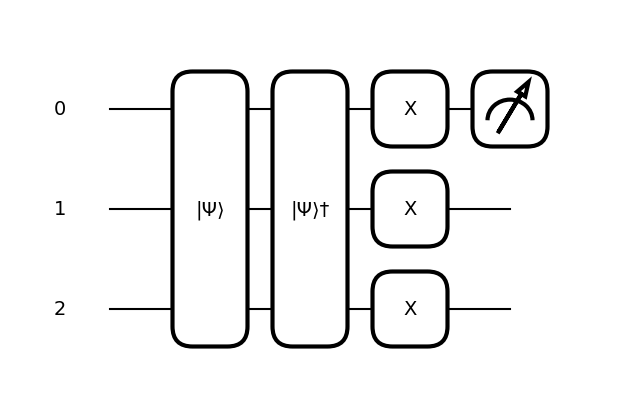

In [312]:
test1 = test(4)
x = torch.tensor([0.1,0.2,0.3,0.4])
res = test1(x)
print("res : ",res)
res.backward()
print(test1.weights.grad)
print(test1.weights)

In [313]:
dot =make_dot(res, params={"w":test1.weights,"bias":test1.bias})
dot.render('computation_graph', format='png', cleanup=True)  # 파일로 저장
dot.view()

'computation_graph.pdf'

[Parameter containing:
tensor([0.3271, 0.5438, 0.8418, 0.4543], requires_grad=True), Parameter containing:
tensor([0.9737], requires_grad=True)]
tensor(1.9235)
tensor([1.9235, 0.1000, 0.2000, 0.3000, 0.4000, 1.0000, 0.0000, 0.0000])
tensor([0.0000, 0.3271, 0.5438, 0.8418, 0.4543, 0.9737, 0.0000, 1.6535],
       grad_fn=<CatBackward0>)
Z : tensor(1.5494, grad_fn=<DotBackward0>)
U z Parameter containing:
tensor([0.3271, 0.5438, 0.8418, 0.4543], requires_grad=True)
(<Figure size 600x400 with 1 Axes>, <Axes: >)
U z Parameter containing:
tensor([0.3271, 0.5438, 0.8418, 0.4543], requires_grad=True)
res: tensor(0.2672, dtype=torch.float64, grad_fn=<DotBackward0>)
tensor([nan, nan, nan, nan])
[Parameter containing:
tensor([nan, nan, nan, nan], requires_grad=True), Parameter containing:
tensor([nan], requires_grad=True)]


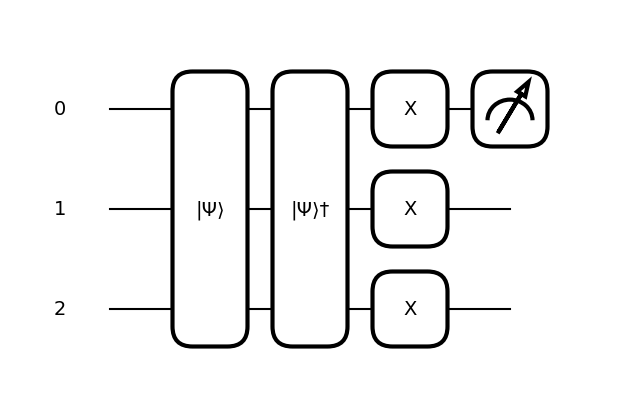

In [302]:
test1 = test(4)
print(list(test1.parameters()))
op1 = optim.Adam(test1.parameters(), lr=0.01)
# op1.zero_grad()
res = test1(x)
print("res:",res)
res.backward()
print(test1.weights.grad)
op1.step()
print(list(test1.parameters()))

In [118]:
class Theorem1: # _for_torch:
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d, l = 0):
        '''
            w(torch.tensor([]))     : list for weight
            x(torch.tensor([]))     : list for x(input)
            b(torch.tensor([]))    : float value of bias
            d(int)      : degree for Taylor (polynomial) Expansion
        '''

        # print('Before list Initiallize Init')
        # list Initiallize
        self.w = w
        self.x = x
        self.b = b
        self.d = d
        self.l = l

        # # vector Initiallize
        # self.x = np.array(self.x_list)
        # self.w = np.array(self.w_list)

        # print('Before lengths Calculate Init')
        # lengths Calculate
        self.N_in = len(self.x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # print('Before A_x, A_wb Calculate Init')
        # A_x, A_wb Calculate
        self.A_x  = torch.sqrt(torch.tensor(self.N_in)- (self.x @ self.x))
        self.A_wb = torch.sqrt(torch.tensor(self.N_in + 1) - (self.w @ self.w + self.b * self.b))

        # print('Before v_x, v_wb Init')
        # v_x, v_wb
        self.v_x    = torch.cat((self.A_x.unsqueeze(0),  self.x, torch.tensor([1.0]), torch.tensor([0.0] * (self.N - self.N_in - 2))))               # [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb   = torch.cat((torch.tensor([0.0]), self.w, self.b, torch.tensor([0.0] * (self.N - self.N_in - 3)), self.A_wb))   # [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        a_m = self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()

        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def corollary1(self, k):
        '''
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        bitstring = ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index]

---

### Theorem 2

In [119]:
class Theorem2(Theorem1):
    def __init__(self, w, x, b, d, f, l = 0):
        '''
            w, x, b, d : same as Thm1
            f(str) : name of function which will be sympified
        '''

        # print('Before Thm1 Init')
        super().__init__(w, x, b, d, l=l)
        # print('After Thm1 Init')
        self.f = sp.sympify(f) # target f
        self.k = -1     # target f의 taylor expansion 중 계수가 0이 아닌 최저 차수
        self.C_d = 1    # f_d(z)와 실제 f(z)의 factoring constant
        self.theta_list = self.make_theta_list()


    def taylor_series_coefficients(self):
        # 심볼 정의
        z = sp.symbols('z')
        point = 0.0

        # 테일러 전개 계산
        taylor_expansion = sp.series(self.f, z, point, self.d + 1).removeO()

        # 계수 추출
        coeffs = [taylor_expansion.coeff(z, i) for i in range(self.d + 1)]
        return coeffs

    def make_theta_list(self):
        # Get Coeffs of Taylor (polynomial) Expansion of target f
        coefficients = self.taylor_series_coefficients()

        # Update k (target f의 taylor expansion 중 계수가 0이 아닌 최저 차수)
        for i in range(0, self.d + 1):
            if coefficients[i] != 0:
                self.k = i
                break

        theta_list = [0 for _ in range(self.d)]
        # target f = 0
        if self.k < 0:
            return theta_list

        # a_i = 0 for all i < k
        for i in range(self.k):
            theta_list[i] = -1 * math.pi / 2

        # a_k Initiallization
        theta_list[self.k] = math.atan(-1 * coefficients[self.k + 1] / coefficients[self.k])

        A = 1
        for i in range(self.k + 1, len(coefficients) - 1):
            A *= math.cos(theta_list[i - 1])
            theta_list[i] = math.atan(-1 * coefficients[i + 1] / coefficients[self.k] * A)

        # C_d update
        C_d = coefficients[self.k] # a_k
        for i in range(self.k, self.d):
            C_d /= math.cos(theta_list[i]) # 1/cos(theta)
        self.C_d = torch.tensor([float(C_d)])

        return theta_list

    def U(self, d):
        '''
            U_d Unitary for S_U iteration
        '''
        theta_list = self.theta_list # make_theta_list()
        for k in range(1, d):
            a_0 = self.n
            a_k = a_0 + k
            qml.ctrl(qml.RY, control=a_k, control_values=0)(2 * theta_list[k - 1], wires=a_0)
            qml.CNOT(wires=[a_0, a_k])

    def outer_theorem2(self):
        '''
            S_U := d register에는 U_d, q register에는 Pauli-X for each qubit
        '''
        # Pauli-X for each qubit of q register
        # and S_V
        self.outer_theorem1()

        qml.Barrier()

        # U_d
        self.U(self.d)

        qml.Barrier()

        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

    def theorem2(self, chk=False):
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem2():
            self.outer_theorem2()
            return qml.state()
        if chk:
            print(qml.draw_mpl(self.outer_theorem2)())
        return inner_theorem2()

    def corollary2(self, k):
        '''
            as same as col 1,
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem2()
        bitstring = ('0' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index] * self.C_d # * C_d


---

### Amplitude Estimation

In [120]:
class qaf_layer(Theorem2):
    def __init__(self, w, x, b, d, f):
        '''
            w, x, b, d : same as Thm1
            f(str) : name of function which will be sympified
        '''
        # print('Before Thm2 Init')
        super().__init__(w, x, b, d, f, l = 1)
        # print('After Thm2 Init')

        self.f = sp.sympify(f) # target f
        self.k = -1 # target f의 taylor expansion 중 계수가 0이 아닌 최저 차수
        self.theta_list = self.make_theta_list()

    def outer_controlled_theorem2(self):
        l_0 = self.n + self.d # index of l register

        qml.Hadamard(wires=l_0) # Hadamard for l register

        qml.Barrier()

        qml.ctrl(self.outer_theorem2, control=l_0)()

        qml.Barrier()

        qml.Hadamard(wires=l_0) # Hadamard for l register

    def controlled_theorem2(self):
        @qml.qnode(device=self.dev, interface="torch")
        def inner_controlled_theorem2():
            self.outer_controlled_theorem2()
            return qml.probs()
        return inner_controlled_theorem2()

    def amplitude_estimation(self):
        result = self.controlled_theorem2()[0] # get P_0
        factorized_inner_product = torch.sqrt(4 * result) - 1
        inner_product = factorized_inner_product * (2 ** (self.d / 2))
        return inner_product

    def activation_estimation(self):
        result = self.amplitude_estimation()
        return result * self.C_d


---

### QAF Model

In [121]:
# list Initiallize
x_tensor = torch.tensor([0.1, -0.2, -0.3, -0.4])
w_tensor = torch.tensor([-0.8, 0.7, 0.9, 0.3])
b = torch.tensor([0.5])
d = 5
f = 'sin(z)'

args = [x_tensor, w_tensor, b, d, f]

N_in = len(x_tensor)
z = (np.array(x_tensor) @ np.array(x_tensor) + b) / (N_in + 1)

target_w = torch.tensor([-0.8, 0.7, 0.9, 0.3])
target_b = torch.tensor([0.5])
# 'f(wx+b) -> f(target_w * x + target_b)'

In [122]:
# 데이터 생성
num_data = 20000  # 총 데이터 개수
batch_size = 1  # 배치 크기

x_data = torch.rand(4, num_data)  # (20000, 1) shape로 생성
y_data = target_w @ x_data + target_b  # sin 함수로 출력 생성 (20000, 1)
x_data = x_data.T
# 텐서 데이터셋 생성
dataset = TensorDataset(x_data, y_data)

# Train/Test set 분할 (80%/20% 비율)
train_size = int(0.8 * num_data)
test_size = num_data - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 생성
train_loader = train_dataset # DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = test_dataset # DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 배치 예시 출력
x_batch, y_batch = next(iter(train_loader))
print("Example batch x:", x_batch.shape)  # Expected: [128, 1]
print("Example batch y:", y_batch.shape)  # Expected: [128, 1]


Example batch x: torch.Size([4])
Example batch y: torch.Size([])


In [123]:
class qaf_model(nn.Module):
    '''
        qaf_layer, 즉 n-to-1 perceptron(wx+b)에서, w가 잘 업데이트 되는지 확인하기 위한 클래스
    '''
    def __init__(self, input_size):
        '''
            input_size(int) : w와 x의 size -> N_in
        '''
        super(qaf_model, self).__init__()

        self.weights = nn.Parameter(torch.rand(input_size, requires_grad=True))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True))
        self.activation = 'sin(z)'

    def forward(self, input, dim=4):
        q_layer = qaf_layer(w=self.weights, x=input, b=self.bias, d=dim, f=self.activation)
        return q_layer.activation_estimation() # .retain_grad()


In [124]:
for e in train_loader:
    x_input = e[0]
    break
x_input

tensor([0.1070, 0.5568, 0.6816, 0.1234])

In [125]:
q2 = qaf_model(4)
res = q2(x_input)
res.backward()
print(q2.weights.grad)

tensor([nan, nan, nan, nan])


In [126]:
q2 = qaf_model(4)

trainer1 = trainer(q2, train_loader=train_loader, test_loader=test_loader)

list(q2.parameters())


[Parameter containing:
 tensor([0.6713, 0.6839, 0.8132, 0.2128], requires_grad=True),
 Parameter containing:
 tensor([0.2675], requires_grad=True)]

In [20]:
for e in train_loader:
    print(e[0])
    break

tensor([0.5354, 0.4039, 0.2914, 0.3696])


In [21]:
trainer1.train(chk=True)

NameError: name 'trainer1' is not defined

In [22]:
q2 = qaf_model(4)

for e in train_loader:
    print(q2.weights.grad)
    print(q2.bias.grad)
    res = q2(e[0])
    res.backward()
    print(q2.weights.grad)
    print(q2.bias.grad)
    break

NameError: name 'qaf_model' is not defined

In [ ]:
list(q2.parameters())

[Parameter containing:
 tensor([0.7701, 0.3137, 0.5186, 0.8166], requires_grad=True),
 Parameter containing:
 tensor([0.3878], requires_grad=True)]